In [1]:
import pytesseract

# download tesseract for windows here and add to path: https://github.com/UB-Mannheim/tesseract/wiki
pytesseract.pytesseract.tesseract_cmd = r"C:/Program Files/Tesseract-OCR/tesseract.exe"

from pdf2image import convert_from_path
import pandas as pd
import cv2
import PIL
import numpy as np
import json
from matplotlib import pyplot as plt

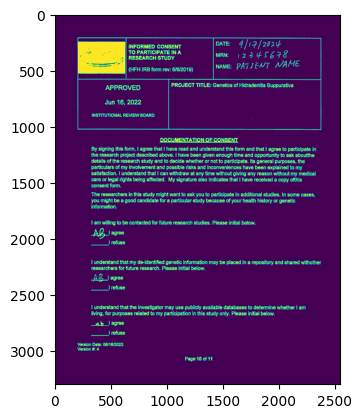

In [5]:
plt.imshow(thresh)

In [21]:
largest_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_contour)

In [25]:
cv2.rectangle(img, [x, x+w], [y, y+h], color = (255,0,255))

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

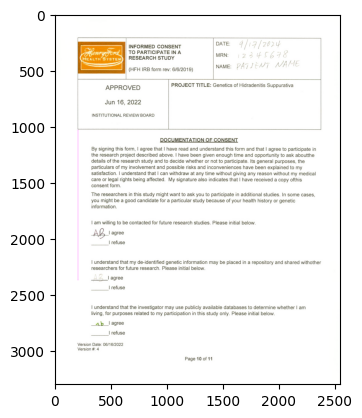

In [26]:
plt.imshow(img)

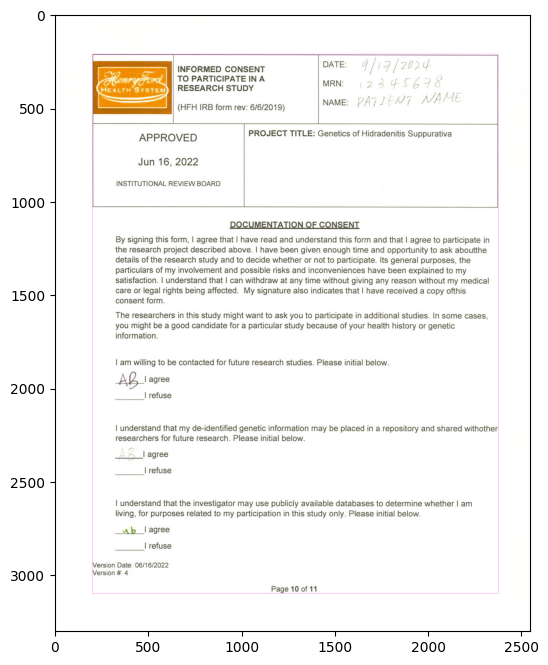

In [30]:
path_to_file = "pg1.jpg"
img = cv2.imread(path_to_file)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize variables for the union bounding box
min_x, min_y = float('inf'), float('inf')
max_x, max_y = float('-inf'), float('-inf')

# Find bounding boxes and compute the union bounding box
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    min_x = min(min_x, x)
    min_y = min(min_y, y)
    max_x = max(max_x, x + w)
    max_y = max(max_y, y + h)

cv2.rectangle(img, [min_x, min_y], [max_x, max_y], color = (255,0,255))

plt.figure(figsize = (8,8))
plt.imshow(img)

In [34]:
proportion_of_header = 0.8831372549019608

def preprocess_pdf(path_to_file):
    """
    PDF Preprocess. Will return two cv2 objects
    """
    pages = convert_from_path(path_to_file, dpi=300)

    if len(pages) != 2:
        raise Exception("Error: Expects PDF with two pages")
    
    p1_name = path_to_file[:-4] + '_pg1.jpg'
    p2_name = path_to_file[:-4] + '_pg2.jpg'

    pages[0].save(p1_name, 'JPEG')
    pages[1].save(p2_name, 'JPEG')

    return (p1_name, p2_name)

def preprocess_jpg(path_to_file, color = False):
    """
    JPG preprocessing with cv2
    applies greyscale, threshold
    """
    img = cv2.imread(path_to_file)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    corners = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
        
    # Dilate corner image to enhance corner points
    corners = cv2.dilate(corners, None)

    # Threshold to get corner coordinates
    threshold = 0.01 * corners.max()
    corner_coords = np.where(corners > threshold)

    # Convert to list of (x, y) coordinates
    corner_points = list(zip(corner_coords[1], corner_coords[0]))

    rect = np.zeros((2, 2), dtype="int")
    s = np.sum(corner_points, axis=1)
    rect[0] = corner_points[np.argmin(s)]  # Top-left
    diff = np.diff(corner_points, axis=1)
    rect[1] = corner_points[np.argmin(diff)]  # Top-right

    # rect contains top corners

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize variables for the union bounding box
    min_x, min_y = float('inf'), float('inf')
    max_x, max_y = float('-inf'), float('-inf')

    # Find bounding boxes and compute the union bounding box
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        min_x = min(min_x, x)
        min_y = min(min_y, y)
        max_x = max(max_x, x + w)
        max_y = max(max_y, y + h)

    if color:
        bounding_rect = img[int(rect[:,1].mean()) : max_y, rect[0][0] : rect[1][0]]
    else:
        bounding_rect = thresh[int(rect[:,1].mean()) : max_y, rect[0][0] : rect[1][0]]

    return cv2.resize(bounding_rect, (2550, 3300))


def preprocess(path_to_file, color = False):
    """"
    Takes in pdf or jpg file and returns a cv2 array applying preprocessing steps above
    If pdf, expects that it is a file containing pg 10, 11 sequentially
    """
    if path_to_file.endswith('.pdf'):
        p1_name, p2_name = preprocess_pdf(path_to_file)
        return [preprocess_jpg(p1_name, color = color),
                preprocess_jpg(p2_name, color = color)]

    elif path_to_file.endswith('.jpg'):
        return preprocess_jpg(path_to_file, color = color)
    
    
    raise Exception("Error: Invalid Input. Must be of type (*.pdf, *jpg)")

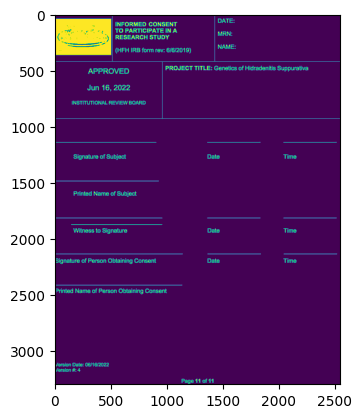

In [51]:
x = preprocess_jpg("blank_pg2.jpg")
cv2.imwrite("blank_pg2_pp.jpg", x)
plt.imshow(x)

In [123]:
"""
proportion_of_header = 0.8831372549019608

def preprocess_pdf(path_to_file):
    """
    PDF Preprocess. Will return two cv2 objects
    """
    pages = convert_from_path(path_to_file, dpi=300)

    if len(pages) != 2:
        raise Exception("Error: Expects PDF with two pages")
    
    p1_name = path_to_file[:-4] + '_pg1.jpg'
    p2_name = path_to_file[:-4] + '_pg2.jpg'

    pages[0].save(p1_name, 'JPEG')
    pages[1].save(p2_name, 'JPEG')

    return (p1_name, p2_name)

def preprocess_jpg(path_to_file, template, threshold):
    """
    JPG preprocessing with cv2
    applies greyscale, threshold
    """
    img = cv2.imread(path_to_file)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if template:
        if threshold:
            _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
            return cv2.resize(thresh, (2550, 3300))
        else:
            return cv2.resize(gray, (2550, 3300))

    corners = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
        
    # Dilate corner image to enhance corner points
    corners = cv2.dilate(corners, None)

    # Threshold to get corner coordinates
    threshold = 0.01 * corners.max()
    corner_coords = np.where(corners > threshold)

    # Convert to list of (x, y) coordinates
    corner_points = list(zip(corner_coords[1], corner_coords[0]))

    rect = np.zeros((2, 2), dtype="int")
    s = np.sum(corner_points, axis=1)
    rect[0] = corner_points[np.argmin(s)]  # Top-left
    diff = np.diff(corner_points, axis=1)
    rect[1] = corner_points[np.argmin(diff)]  # Top-right

    print(rect)

    img_header_length = rect[1][0] - rect[0][0]

    print(img_header_length)
    
    p = int((img_header_length - proportion_of_header * img.shape[1]) / (-2 * proportion_of_header))
    old_dim = img.shape
    cropped_image = gray[p: (old_dim[0]-p), p:(old_dim[1]-p)]

    print(old_dim)

    print(p)

    print(cropped_image.shape)

    if threshold:
        _, thresh = cv2.threshold(cropped_image, 240, 255, cv2.THRESH_BINARY_INV)
        return cv2.resize(thresh, (2550, 3300))
    
    else:
        return cv2.resize(cropped_image, (2550, 3300))


def preprocess(path_to_file, template = False, threshold = True):
    """"
    Takes in pdf or jpg file and returns a cv2 array applying preprocessing steps above
    If pdf, expects that it is a file containing pg 10, 11 sequentially
    """
    if path_to_file.endswith('.pdf'):
        p1_name, p2_name = preprocess_pdf(path_to_file)
        return [preprocess_jpg(p1_name, template, threshold),
                preprocess_jpg(p2_name, template, threshold)]

    elif path_to_file.endswith('.jpg'):
        return preprocess_jpg(path_to_file, template, threshold)
    
    
    raise Exception("Error: Invalid Input. Must be of type (*.pdf, *jpg)")
"""

In [126]:
d = cv2.imread("blank_pg1.jpg")
d.shape

(3301, 2550, 3)

In [124]:
#b1, b2 = preprocess('blank.pdf', template = True)
#pg1 = preprocess('pg1.jpg')
pg2 = preprocess('pg2.jpg')

[[ 203  208]
 [2375  215]]
2172
(3301, 2548, 3)
44
(3213, 2460)


In [34]:
x = np.array([[203 ,208],[2375 , 215]])

In [38]:
int(x[:,1].mean())

211.5

In [125]:
b1.shape

(3300, 2550)

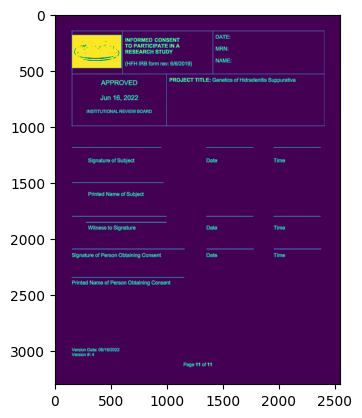

In [64]:
plt.imshow(b2)

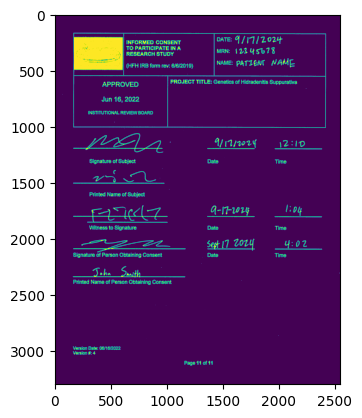

In [92]:
plt.imshow(pg2)

In [3]:
with open("pg1_annotations_n.json", 'r') as file:
    pg1_annotations = json.load(file)

In [159]:
# show annotations pg1

pg1_orig = cv2.resize(cv2.imread("blank_pg1_pp.jpg"), (2550, 3300))

for shape in pg1_annotations['shapes']:

    cv2.rectangle(pg1_orig, np.array(shape['points'][0], dtype = np.int32), np.array(shape['points'][1], dtype = np.int32), (255, 0, 0), 2)
    
    bottom_left_coord = np.array(shape['points'][0], dtype = np.int32)
    text = shape['label']
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 2
    font_thickness = 5
    text_color_bg = (0,50,50)
    x, y = bottom_left_coord

    cv2.putText(pg1_orig, shape['label'], bottom_left_coord + [10, 50], font, font_scale, (225,0,0), font_thickness)

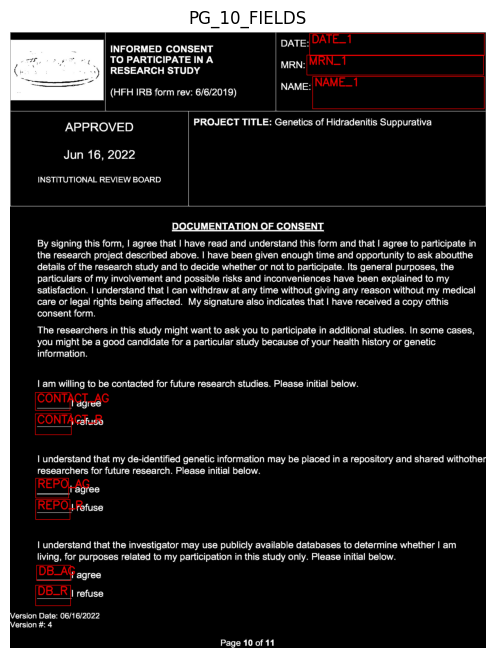

In [160]:
plt.figure(figsize=(12, 8))
plt.axis("off")
plt.title("PG_10_FIELDS")
plt.imshow(pg1_orig)

In [4]:
with open("pg2_annotations_n.json", 'r') as file:
    pg2_annotations = json.load(file)

In [161]:
# show annotations pg1

pg2_orig = cv2.resize(cv2.imread("blank_pg2_pp.jpg"), (2550, 3300))

for shape in pg2_annotations['shapes']:

    cv2.rectangle(pg2_orig, np.array(shape['points'][0], dtype = np.int32), np.array(shape['points'][1], dtype = np.int32), (255, 0, 0), 2)
    
    bottom_left_coord = np.array(shape['points'][0], dtype = np.int32)
    text = shape['label']
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 2
    font_thickness = 5
    text_color_bg = (0,50,50)
    x, y = bottom_left_coord

    cv2.putText(pg2_orig, shape['label'], bottom_left_coord + [10, 50], font, font_scale, (225,0,0), font_thickness)

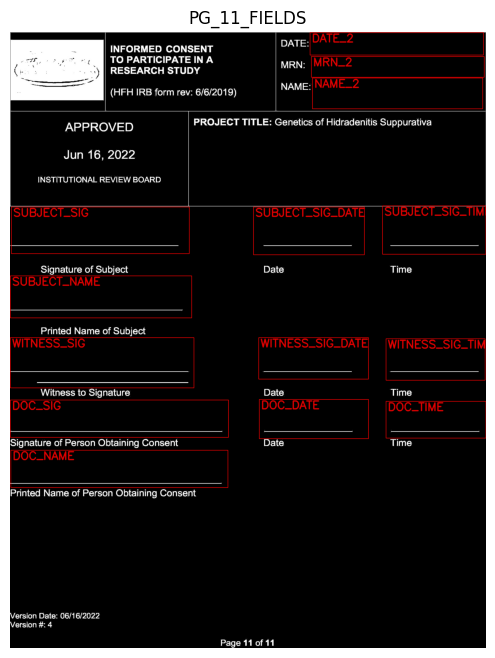

In [162]:
plt.figure(figsize=(12, 8))
plt.axis("off")
plt.title("PG_11_FIELDS")
plt.imshow(pg2_orig)

In [61]:
pg1 = preprocess("pg1.jpg")

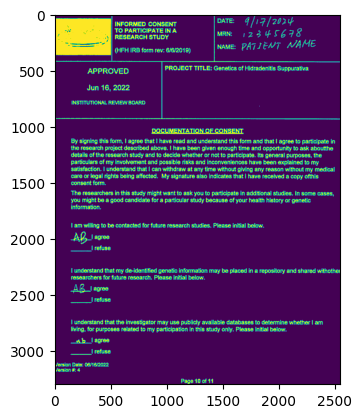

In [63]:
plt.imshow(pg1)

In [58]:
# same perf as pytesseract

from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
from PIL import Image
import numpy as np
import os

# Monkey-patch transformers to avoid TensorFlow checks
import transformers.utils.generic as generic
generic.is_tf_available = lambda: False
generic.is_tf_tensor = lambda x: False

# Change working directory
os.chdir(r'C:\Users\randymi\Desktop\ocr_test')

def evaluate_vit_on_image(model, processor, image_array):
    # Load and preprocess the image
    image = Image.fromarray(image_array).convert('RGB')
    
    # Convert PIL Image to numpy array
    image_np = np.array(image)
    
    # Use processor with numpy array
    inputs = processor(images=image_np, return_tensors="pt")

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted class and confidence
    logits = outputs.logits
    predicted_class_idx = torch.argmax(logits, dim=1).item()

    # MNIST classes are digits 0-9
    predicted_label = str(predicted_class_idx)

    return predicted_label

def preprocess_image(binary):
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours from left to right
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])
    
    return binary, contours


def recognize_number(image_path):
    # Load the pre-trained processor and model
    processor = AutoImageProcessor.from_pretrained("farleyknight-org-username/vit-base-mnist")
    model = AutoModelForImageClassification.from_pretrained("farleyknight-org-username/vit-base-mnist")
    
    # Preprocess the image and get contours
    image, contours = preprocess_image(image_path)
    
    recognized_digits = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w * h > 100:  # Filter out very small contours
            digit_image = image[y:y+h, x:x+w]
            digit = evaluate_vit_on_image(model, processor, digit_image)
            recognized_digits.append(digit)
    print(recognized_digits)
    return ''.join(recognized_digits)

bbox_dim = pg1_annotations['shapes'][1]['points']

bbox = pg1[int(bbox_dim[0][1]) : int(bbox_dim[1][1]),
            int(bbox_dim[0][0]) : int(bbox_dim[1][0])]

recognize_number(bbox)

In [133]:
'1'.isdigit()

True

In [146]:
pg1_text = {}
pg1 = preprocess('pg1.jpg')
pg2 = preprocess('pg2.jpg')
pg1_blank = preprocess('blank_pg1.jpg')
pg2_blank = preprocess('blank_pg2.jpg')

with open("pg1_annotations_n.json", 'r') as file:
    pg1_annotations = json.load(file)

with open("pg2_annotations_n.json", 'r') as file:
    pg2_annotations = json.load(file)

text_fields = ["DATE_1", "MRN_1", "MRN_2", "NAME_1", "NAME_2","DATE_2", "MRN_2", "DOC_NAME", "DATE_2"]

decision_fields = ["CONTACT", "REPO", "DB"]

def all_numeric(i_str : str) -> bool:
    for i in i_str:
        if not i.isdigit():
            return False
    return True

def get_text(preprocessed_img, annotations, validation_mode = False, conf_min = 50):
    text = {}
    for shape in annotations['shapes']:
        bbox_dim = shape['points']
        bbox = preprocessed_img[int(bbox_dim[0][1]) : int(bbox_dim[1][1]),
                int(bbox_dim[0][0]) : int(bbox_dim[1][0])]
        
        #plt.figure(figsize=(12, 8))
        #plt.imshow(bbox)
        #plt.title(shape['label'])
        #plt.show()
        
        if shape['label'] in text_fields and not validation_mode:
            output = pytesseract.image_to_string(bbox, lang = 'eng')
            data = pytesseract.image_to_data(bbox, lang='eng', output_type=pytesseract.Output.DATAFRAME)
            # Filter out rows with no text
            data = data[data['text'].notna()]
            if len(data) == 0:
                text[shape['label']] = None
            else:
                dval = data.sort_values('conf', ascending = False).iloc[0]
                output_val = output.strip()
                if dval.conf < conf_min:  
                    output_val = None
                else:
                    # MRN Validation
                    if shape['label'].startswith('MRN'):
                        if not all_numeric(output_val):
                            output_val = None        
                            
                text[shape['label']] = output_val      
        else:
            #report average weight
            text[shape['label']] = bbox.flatten().mean()

    return text

base_weight_pg2 = get_text(pg2_blank, pg2_annotations, validation_mode = True)
base_weight_pg1 = get_text(pg1_blank, pg1_annotations, validation_mode = True)

In [156]:
import pickle

with open("templates/base_weight_pg2.pkl", "wb") as file:
    pickle.dump(base_weight_pg2, file)

with open("templates/base_weight_pg1.pkl", "wb") as file:
    pickle.dump(base_weight_pg1, file)

In [148]:
fields = {}

# process pg1
for pg, annotation, base_weight in zip([pg1, pg2], [pg1_annotations, pg2_annotations], [base_weight_pg1, base_weight_pg2]):
    pg_text = get_text(pg, annotation)
    for field, val in pg_text.items():
        
        if field in text_fields:
            fields[field] = pg_text[field]
            continue
        root = field.split('_')[0]
        if root in decision_fields:
            if (pg_text[root + '_R'] / base_weight[root + '_R']) > (pg_text[root + '_AG'] / base_weight[root + '_AG']):
                fields[root] = 'REFUSED'
            else:
                fields[root] = 'AGREED'
            continue

        # all that is left is exit fields
        if (pg_text[field] / base_weight[field]) > 1.1:
            fields[field] = "EXISTS"
        else:
            fields[field] = "MISSING"



In [149]:
fields

{'DATE_1': '4/17/2024',
 'MRN_1': None,
 'NAME_1': 'PATIENT MAME',
 'CONTACT': 'AGREED',
 'REPO': 'AGREED',
 'DB': 'AGREED',
 'DATE_2': None,
 'MRN_2': None,
 'NAME_2': 'PATIENT NAME',
 'SUBJECT_SIG_DATE': 'EXISTS',
 'SUBJECT_SIG_TIME': 'EXISTS',
 'SUBJECT_SIG': 'EXISTS',
 'SUBJECT_NAME': 'EXISTS',
 'WITNESS_SIG': 'EXISTS',
 'DOC_SIG': 'EXISTS',
 'DOC_NAME': None,
 'WITNESS_SIG_DATE': 'EXISTS',
 'WITNESS_SIG_TIME': 'EXISTS',
 'DOC_DATE': 'EXISTS',
 'DOC_TIME': 'EXISTS'}

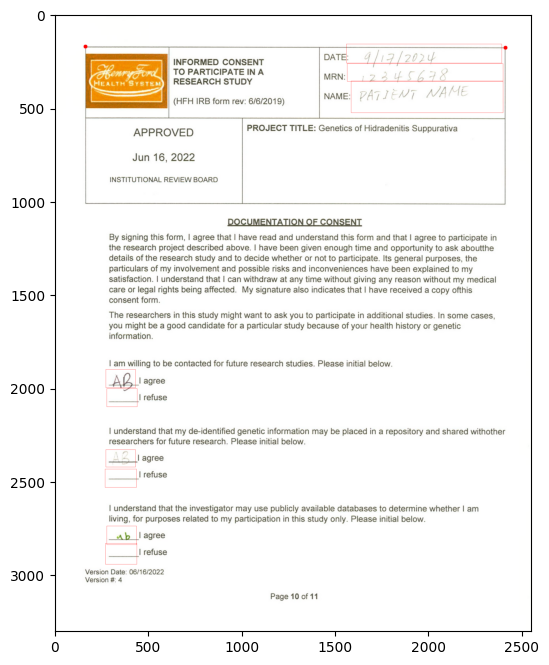

In [58]:
plt.figure(figsize=(12, 8))

plt.imshow(x)

In [218]:
text = pytesseract.image_to_string(bbox, lang='eng')

In [219]:
text

'PATIENT MAME\n'

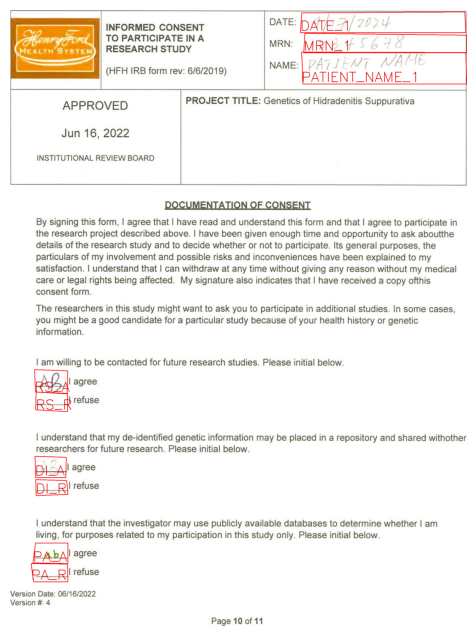

In [173]:
plt.figure(figsize=(12, 8))
plt.axis("off")
plt.imshow(orig_bound_pic)

In [ ]:

def preprocessing(img)
    """ Converts to greyscale, removes noise, then applies binarization"""

In [22]:
img

NameError: name 'img' is not defined

In [9]:
ocr_data = pytesseract.image_to_data(page[0], output_type=pytesseract.Output.DATAFRAME)

In [18]:
non_na_text = ocr_data[~ocr_data.text.isna()]

non_na_text[non_na_text["text"].str.contains("agree")]

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
99,5,1,13,1,1,6,506,796,73,22,96.633423,agree
111,5,1,13,1,1,18,1269,797,73,23,96.219223,agree
265,5,1,16,1,1,2,336,1295,73,22,96.227295,agree
302,5,1,19,1,1,2,331,1563,73,23,95.855537,agree
345,5,1,22,1,1,2,321,1827,88,28,11.974075,_|agree
